In [1]:
import poloniex
polo = poloniex.Poloniex()
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import quandl
import os 
from datetime import datetime
import shutil
import requests
from bs4 import BeautifulSoup
from selenium import webdriver

In [2]:
available_currencies = ['ETH','LTC','XRP','DASH','XMR','BTC','BCH']
altcoins = ['ETH','LTC','XRP','DASH','XMR','XEM']
possible_pairs = list(polo.returnOrderBook().keys())
currencies  = list(polo.returnCurrencies().keys())

In [3]:
def add_crypto_to_portfolio(acronym, amount,portfolio):
    portfolio[acronym] += amount
    
def update_portfolio(actions,portfolio):
    #actions = [{'action':'buy', 'pair':'BTC_AMP', 'rate':1,'amount':100},...]
    for instruction in actions:
        rate, amount, pair = instruction['rate'],instruction['amount'],instruction['pair']
        if(instruction['action'] == 'buy'):
            buy,sell = pair.split('_')
            if(portfolio[sell] - rate*amount >=0):
                portfolio[buy] = portfolio[buy] + amount
                portfolio[sell] = portfolio[sell] - rate*amount
                #print("Bought",amount,buy,"for",rate*amount,sell)
            else:
                pass
                #print("Not enough funds to buy",amount,buy,"for",rate*amount,sell)
                
def get_price(pair):
    if(pair in possible_pairs):
        return float(polo.returnTicker()[pair]['last'])
    else:
        try:
            buy, sell = pair.split("_")
            return float(polo.returnTicker()[sell+"_"+buy]['last'])
        except:
            #print("error")
            return 0

def get_btc_price(alt_acronym):
    if(alt_acronym == 'BTC'):
        return 1
    try:
        return float(polo.returnTicker()['BTC_'+alt_acronym]['last'])
    except:
        try:
            return 1/float(polo.returnTicker()[alt_acronym+'_BTC']['last'])
        except:
            return 0
    

def get_portfolio_value(portfolio):
    value = 0
    for x in portfolio.keys():
        if(x == 'BTC'):
            value += portfolio[x]
        else:
            value += get_btc_price(x)*portfolio[x]
    return value

def do_random_transaction(portfolio):
    current_currencies = list(portfolio.keys())
    transaction_done = False
    while(not transaction_done):
        x = current_currencies[random.randint(0,len(current_currencies)-1)]
        y = available_currencies[random.randint(0,len(available_currencies)-1)]
        pair = y+"_"+x  # buy y sell x
        inverted_pair = x+"_"+y
        if(pair in possible_pairs):
            current_price = 1/float(polo.returnTicker()[pair]['last'])
        elif(inverted_pair in possible_pairs):
            current_price = float(polo.returnTicker()[inverted_pair]['last'])
        else:
            continue
        max_buy_amount = int(portfolio[x]/current_price)
        update_portfolio([{'action':'buy', 'pair':pair, 'rate':current_price,'amount':random.randint(int(0.1*max_buy_amount),max_buy_amount)}],portfolio)
        transaction_done = True

In [4]:
def update_proportions(portfolio, proportions):
    total = 0
    for x in available_currencies:
        value = portfolio[x]*get_btc_price(x)
        proportions[x].append(value)
        total += value
    n = len(list(proportions.values())[0])
    for x in proportions:
        proportions[x][n-1] /= total

In [5]:
class LiveTestNotebook(object):
    

    def __init__(self):
        %matplotlib notebook
        fig = plt.figure(figsize=(13,13))
        
        self.fig = fig

    def update(self, x,proportions,stds, init = False): 
        grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3, width_ratios=[1, 2,0], height_ratios=[1, 1, 1])
        plt.subplot(grid[0, :])
        plt.plot(range(len(x)),list(x),'b')
        plt.axhline(y=x[0], color='r', linestyle='-')
        plt.title('Portfolio value') 
        plt.xlabel('Timesteps')
        plt.ylabel('Portfolio value (BTC)')

        plt.grid(True)
        
        plt.subplot(grid[1, 0],aspect='equal')
        current_proportions = [list(proportions.values())[i][-1] for i in range(len(available_currencies))]

        # Create a circle for the center of the plot
        my_circle=plt.Circle( (0,0), 0.7, color='white')
        # Give color names
        labels = [str(round(y*100,1))+ "% "+x for (x,y) in zip(list(proportions.keys()), [list(proportions.values())[i][-1] for i in range(len(available_currencies))])]
        plt.pie(current_proportions, labels=labels, colors=sns.color_palette())
        p=plt.gcf()
        plt.title('Portfolio content')
        p.gca().add_artist(my_circle)
        
        plt.subplot(grid[1, 1:])
        size = len(list(proportions.values())[0])
        plt.xlabel('Timesteps')
        plt.ylabel('Proportions')
        if(init):
            plt.stackplot(list(range(size)),list(proportions.values()),colors=sns.color_palette(),labels = current_portfolio.keys())
            init = False
        else:
            plt.stackplot(list(range(size)),list(proportions.values()),colors=sns.color_palette())
        plt.legend(loc='upper left')       
        plt.title('Evolution of portfolio')
        
        plt.subplot(grid[2, :])
        # update price
        plt.plot(range(len(stds[0])),stds[0],'b')
        plt.plot(range(len(stds[1])),stds[1],'r')
        plt.title('Portfolio volatility') 
        plt.xlabel('Timesteps')
        plt.ylabel('std')
        plt.legend(['Portfolio Volatility','Bitcoin Volatility'])
        plt.grid(True)
 
        self.fig.canvas.draw()
        

# Retrieve Data

In [6]:
def get_json_data(json_url, cache_path):
    '''Download and cache JSON data, return as a dataframe.'''
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    return df

base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2015-01-01', '%Y-%m-%d') # get data from the start of 2015
end_date = datetime.now() # up until today
pediod = 86400 # pull daily data (86,400 seconds per day)

def get_crypto_data(poloniex_pair):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), pediod)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

#btc_usd_price_kraken = get_quandl_data('BCHARTS/KRAKENUSD')

exchanges = ['COINBASE','BITSTAMP','ITBIT']

exchange_data = {}

#exchange_data['KRAKEN'] = btc_usd_price_kraken

"""for exchange in exchanges:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code)
    exchange_data[exchange] = btc_exchange_df"""

def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

"""btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')
btc_usd_datasets.replace(0, np.nan, inplace=True)
# Calculate the average BTC price as a new column
btc_usd_datasets['avg_btc_price_usd'] = btc_usd_datasets.mean(axis=1)"""


def monte_carlo(combined_df, altcoin, num_portfolio):
    returns = combined_df.pct_change()
    mean_daily_return = returns.mean()
    cov_matrix = returns.cov()

    results = np.zeros((4 + len(altcoins), num_portfolio))
    results_weight = np.zeros((1 + len(altcoins), num_portfolio))
    for i in range(num_portfolio):
        weights = np.array(np.random.random(7))
        weights /= np.sum(weights)

        portfolio_return = np.sum(mean_daily_return*weights)*1140
        portfolio_std  = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))*np.sqrt(1140)

        results[0,i] = portfolio_return
        results[1,i] = portfolio_std
        results[2,i] = results[0,i]/results[1,i]

        for j in range(len(weights)):
            results[j+3, i] = weights[j]
            results_weight[j, i] = weights[j]

    mean = np.zeros(num_portfolio)
    for i in range(num_portfolio):
        mean[i]= results[0, i]

    std = np.zeros(num_portfolio)
    for i in range(num_portfolio):
        std[i]= results[1, i]

    ratio = np.zeros(num_portfolio)
    for i in range(num_portfolio):
        ratio[i]= results[0, i]/ results[1,i]
    return mean, std, ratio, results_weight

def return_proportion(ratio_c, results_weight_c,std_c):
    maxi = np.argmax(ratio_c)
    return results_weight_c[:,maxi],std_c[maxi]

def get_optimal_weight(combined_df_2018, altcoin = altcoins, num_portfolio=5000):
    mean_c, std_c, ratio_c, results_weight_c = monte_carlo(combined_df_2018, altcoin = altcoins, num_portfolio=5000)
    optimal_weight,std = return_proportion(ratio_c, results_weight_c,std_c)
    return [(lambda x : round(x,2)/100)(y) for y in optimal_weight*100],std

def weights_to_portfolio(portfolio,weights,available_currencies):
    value = get_portfolio_value(portfolio)
    btc_equivalent = [value*x for x in weights]
    new_portfolio = {}
    for i in range(len(btc_equivalent)):
        if(available_currencies[i]!='BTC'):
            new_portfolio[available_currencies[i]] = btc_equivalent[i]/get_btc_price(available_currencies[i])
        else:
            new_portfolio['BTC'] = btc_equivalent[i]
    return new_portfolio

# Start Bot

In [7]:
def get_combined_df():
    df = pd.DataFrame(columns=['Date']+available_currencies)
    df['Date'] = pd.read_csv('data/BTC.csv',header=None).iloc[:,0]
    for c in available_currencies:
        df[c] = pd.read_csv('./data/'+c+'.csv',header=None).iloc[:,1]
    df = df.set_index('Date')
    return df

In [8]:
def get_btc_volatility():
    driver = webdriver.Chrome()
    driver.get('https://bitvol.info/')
    html = driver.page_source
    soup = BeautifulSoup(html, 'lxml')
    std = soup.find('span',{'class':'volatility30'})
    driver.close()
    return float(std.text[:-1])

<IPython.core.display.Javascript object>


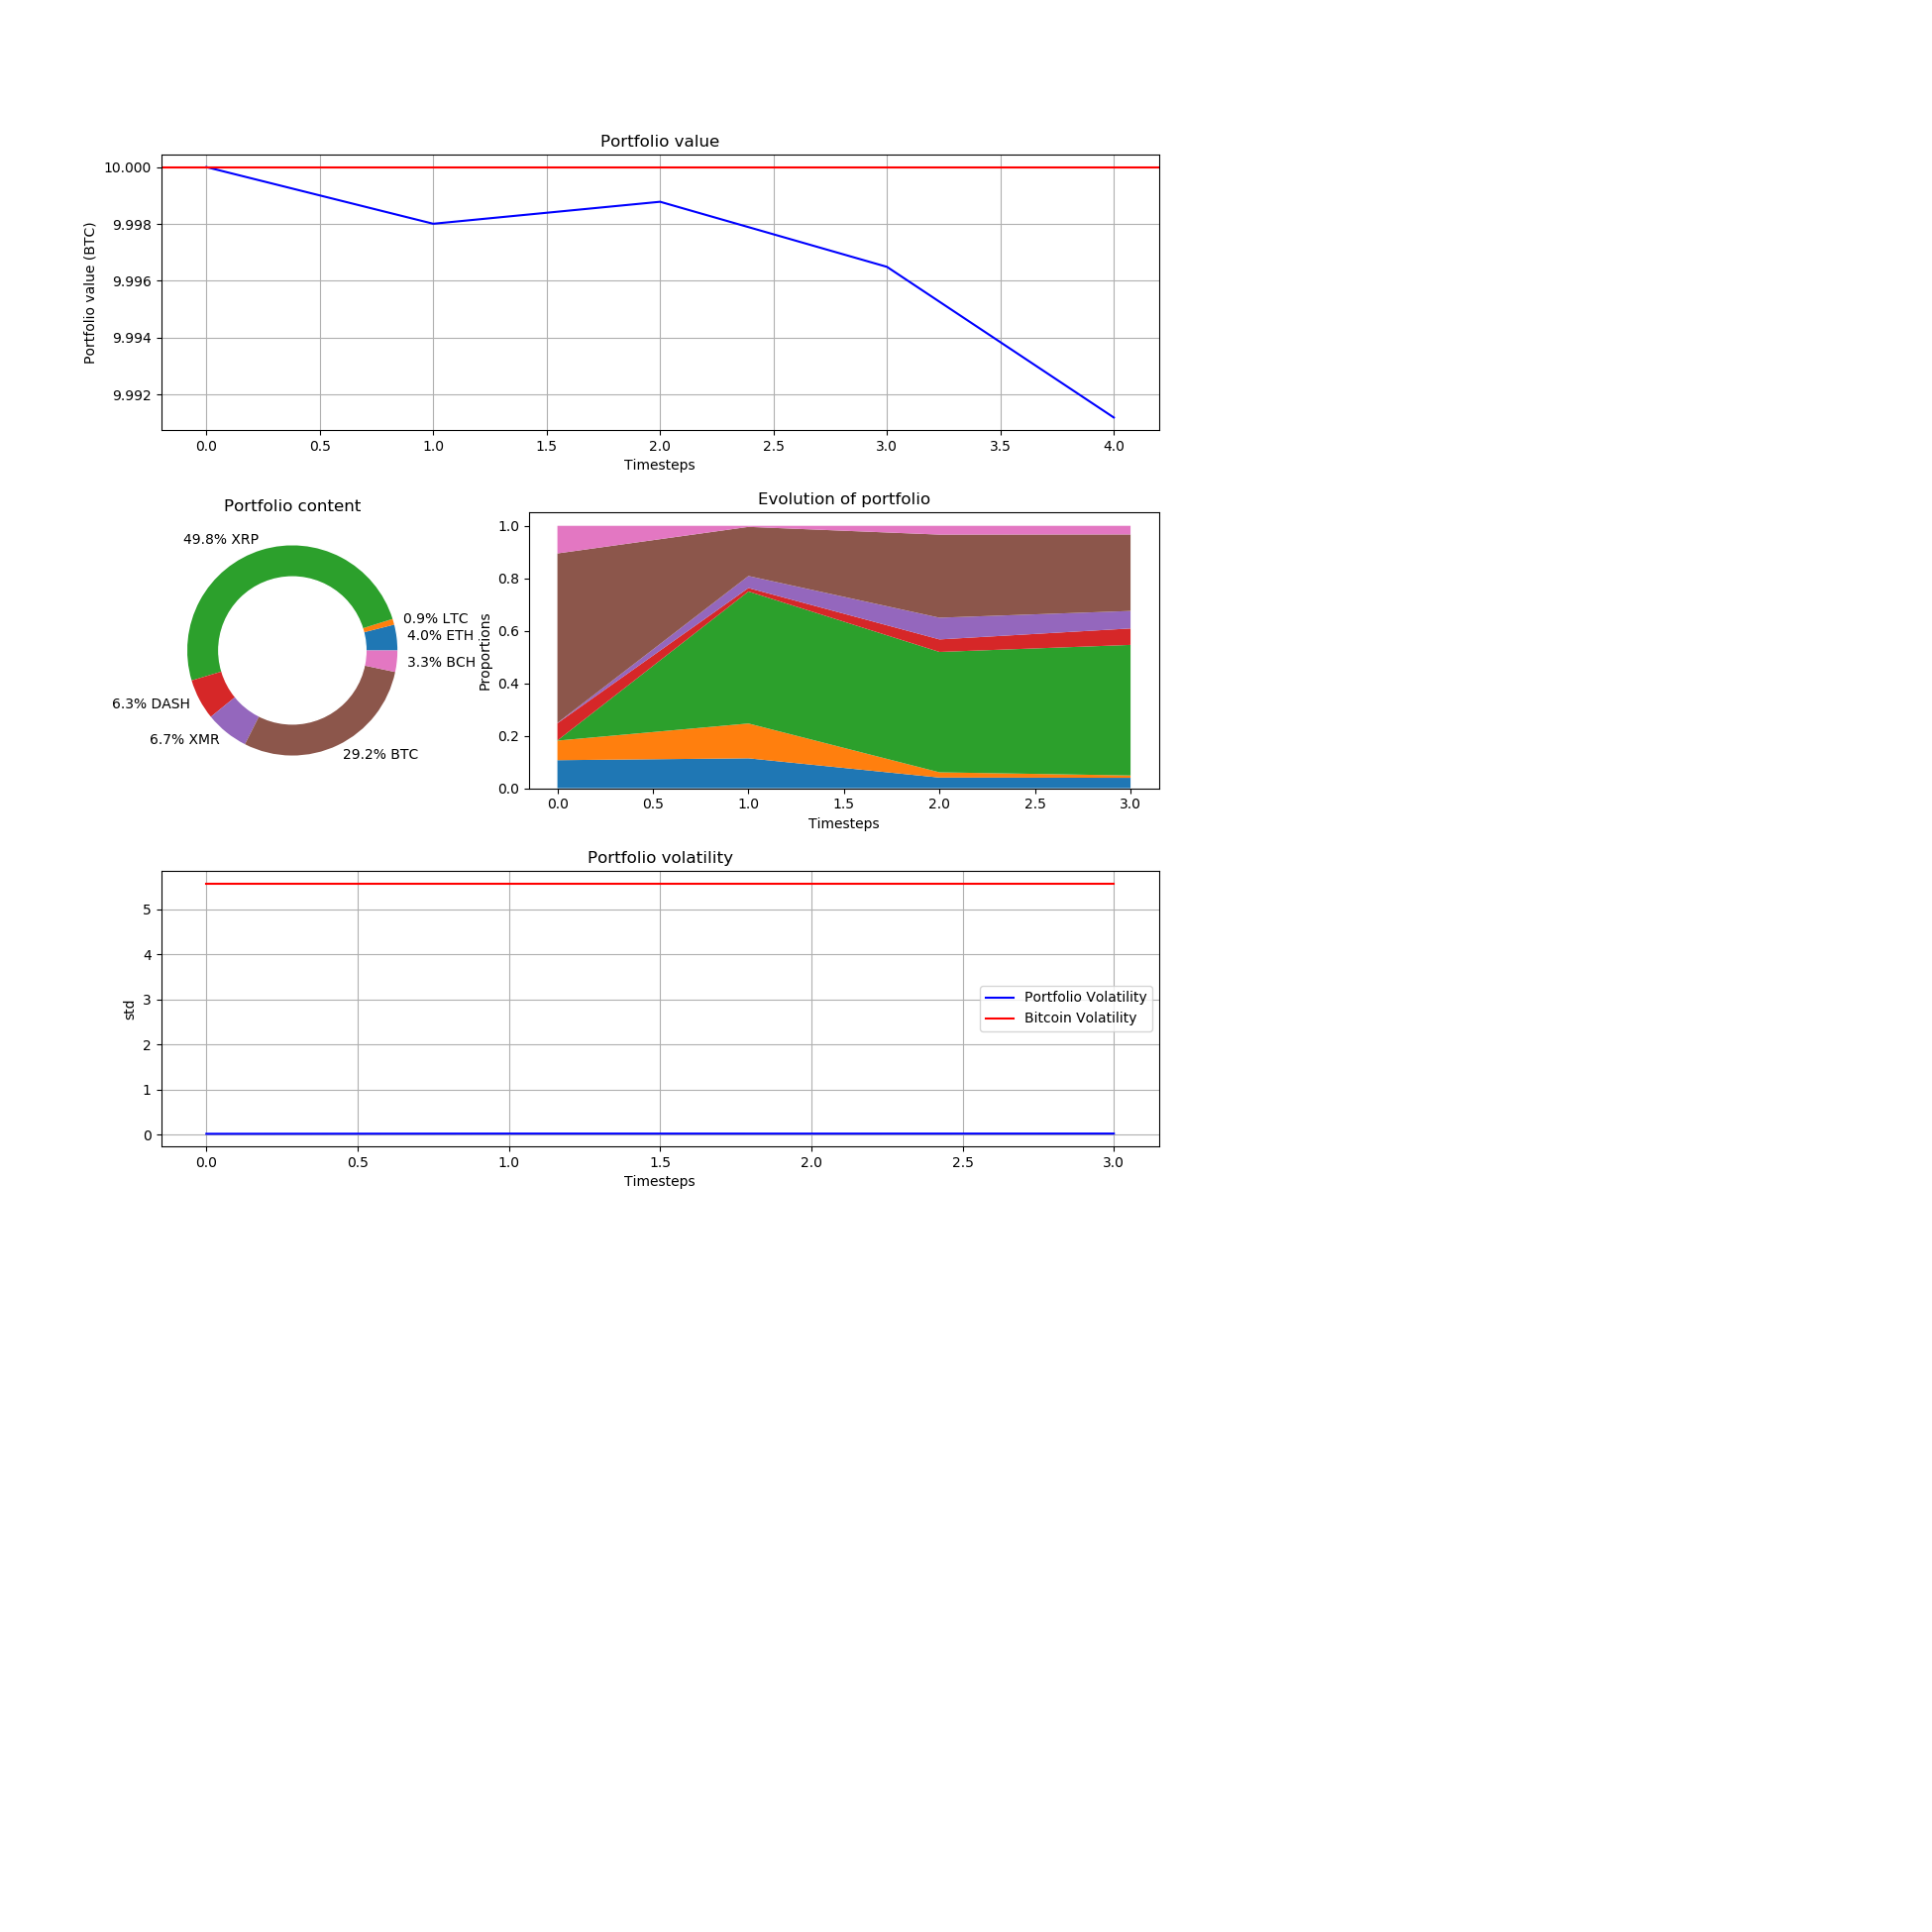

KeyboardInterrupt: 

In [9]:
current_portfolio = defaultdict(int)
proportions = defaultdict(list)
liveplot = LiveTestNotebook()
add_crypto_to_portfolio('BTC',10,current_portfolio)
initial_portfolio = current_portfolio


x= [get_portfolio_value(current_portfolio)]
actions = [0]
i=0
btc_stds = []
stds = []
while(1):
    time.sleep(1)
    combined_df = get_combined_df()
    weights, std = get_optimal_weight(combined_df, altcoin = available_currencies, num_portfolio=8000)
    btc_stds.append(get_btc_volatility())
    stds.append(std)
    current_portfolio = weights_to_portfolio(current_portfolio,weights,available_currencies)
    value = get_portfolio_value(current_portfolio)
    x.append(value)
    actions.append(random.randint(0, 1))
    update_proportions(current_portfolio,proportions)
    liveplot.update(x,proportions,[stds,btc_stds], (i==0))
    i=1

In [ ]:
if not os.path.exists('./data'):
    os.makedirs('./data')
timestep = 5
i = 0    
while(1):
    i+=1
    for c in available_currencies:
        if c+'.csv' not in os.listdir('data'):
            with open('./data/'+c+'.csv','w')as f:
                f.write(str(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))+","+str(get_price(c+'_USDT'))+"\n")
        else:
            with open('./data/'+c+'.csv','a')as f:
                f.write(str(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))+", "+str(get_price(c+'_USDT'))+"\n")
        if(i%60==0):
            try:
                shutil.copyfile('./data/'+c+'.csv', './data/'+c+'_copy.csv')
            except:
                pass
    time.sleep(timestep)